In [2]:
import torch
import torchvision
import torchvision.models as models

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
inception = models.inception_v3(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 106MB/s]


In [5]:
from torchvision import transforms as T

transforms = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_dataset = torchvision.datasets.STL10(
    root="./",
    download=True,
    split="train",
    transform=transforms
)
test_dataset = torchvision.datasets.STL10(
    root="./",
    split="test",
    download=True,
    transform=transforms
)

train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

100%|██████████| 2640397119/2640397119 [02:18<00:00, 19068155.82it/s]


Extracting ./stl10_binary.tar.gz to ./
Files already downloaded and verified


In [7]:
inception.fc = torch.nn.Linear(2048, 10)

In [8]:
for name, param in inception.named_parameters():
  if "Mixed_7c" in name or "fc" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

(-0.5, 298.5, 298.5, -0.5)

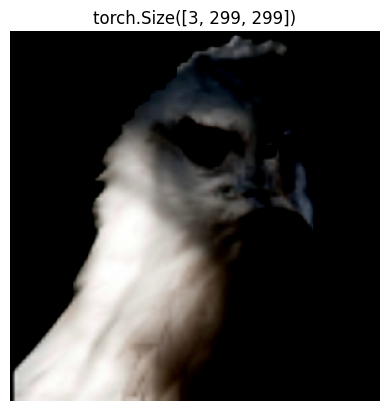

In [9]:
import matplotlib.pyplot as plt

image, label = next(iter(train_dataloader))
plt.imshow(image[0].permute(1, 2, 0))
plt.title(image[0].shape)
plt.axis(False)

In [10]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """
  Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculations, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu")

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    (0.1112, 0.8765)
  """
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred, aux_outputs = model(X)

    # Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimzer Step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """
  Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    los_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    (0.0223, 0.8976)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  return test_loss, test_acc

In [12]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
) -> Dict[str, List]:
  """
  Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model in the
  same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader intance for the model to be tested on.
    optimizer: A PyTorch optimzier to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to comput on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and testing
    accuracy metrics. Each metric has a value in a list for each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                  {train_loss: [2.0492, 1.2849],
                  train_acc: [0.8029, 0.8723],
                  test_loss: [2.3482, 1.9870],
                  test_acc: [0.7425, 0.8029]}
  """
  # Create empty dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(
        f"Epoch: {epoch + 1} | "
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
      )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


  return results

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inception.parameters(), lr=0.001, weight_decay=0.001)

In [16]:
inception.to(device)
train(
    model=inception,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1292 |train_acc: 0.9628 | test_loss: 0.1342 | test_acc: 0.9586
Epoch: 2 | train_loss: 0.1120 |train_acc: 0.9672 | test_loss: 0.1253 | test_acc: 0.9607
Epoch: 3 | train_loss: 0.0840 |train_acc: 0.9761 | test_loss: 0.1395 | test_acc: 0.9570
Epoch: 4 | train_loss: 0.0610 |train_acc: 0.9843 | test_loss: 0.1360 | test_acc: 0.9603
Epoch: 5 | train_loss: 0.0718 |train_acc: 0.9803 | test_loss: 0.1445 | test_acc: 0.9563


{'train_loss': [0.12915389728584106,
  0.11196305157296407,
  0.08398332032167417,
  0.06099712330503923,
  0.07182425383929235],
 'train_acc': [0.9627786624203821,
  0.9671576433121019,
  0.9761146496815286,
  0.9842754777070064,
  0.9802945859872612],
 'test_loss': [tensor(0.1342, device='cuda:0'),
  tensor(0.1253, device='cuda:0'),
  tensor(0.1395, device='cuda:0'),
  tensor(0.1360, device='cuda:0'),
  tensor(0.1445, device='cuda:0')],
 'test_acc': [0.958625, 0.96075, 0.957, 0.96025, 0.95625]}

In [17]:
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [20]:
from torchsummary import summary
inception.to(device)
summary(inception, (3, 299, 299), 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 149, 149]             864
       BatchNorm2d-2         [32, 32, 149, 149]              64
       BasicConv2d-3         [32, 32, 149, 149]               0
            Conv2d-4         [32, 32, 147, 147]           9,216
       BatchNorm2d-5         [32, 32, 147, 147]              64
       BasicConv2d-6         [32, 32, 147, 147]               0
            Conv2d-7         [32, 64, 147, 147]          18,432
       BatchNorm2d-8         [32, 64, 147, 147]             128
       BasicConv2d-9         [32, 64, 147, 147]               0
        MaxPool2d-10           [32, 64, 73, 73]               0
           Conv2d-11           [32, 80, 73, 73]           5,120
      BatchNorm2d-12           [32, 80, 73, 73]             160
      BasicConv2d-13           [32, 80, 73, 73]               0
           Conv2d-14          [32, 192,

In [19]:
stl10_classes = [
    'airplane', 'bird', 'car', 'cat', 'deer',
    'dog', 'horse', 'monkey', 'ship', 'truck'
]


In [ ]:
import os
os.mkdir("./data")

In [34]:
from pathlib import Path
import requests

urls = [
    "https://www.shutterstock.com/image-photo/airplane-isolated-on-white-background-600nw-2348048513.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRl4-hr1THkzHDJAkhsIs71ZPJ7AiXI0KpT_GsLJ1vjJw&s",
    "https://www.shutterstock.com/image-photo/modern-subcompact-crossover-suv-beautiful-600nw-2265832113.jpg",
    "https://img.freepik.com/free-photo/red-white-cat-i-white-studio_155003-13189.jpg",
    "https://www.shutterstock.com/image-photo/sunlit-red-deer-cervus-elaphus-600nw-1722903079.jpg",
    "https://thumbs.dreamstime.com/b/golden-retriever-dog-sitting-white-24750790.jpg",
    "https://media.istockphoto.com/id/483797166/photo/andalusian-horse.jpg?s=612x612&w=0&k=20&c=2Xu8veyHqHMZP7OAJwkfihgJo0bsGhz0e1yGAGw7E4Y=",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Bonnet_macaque_%28Macaca_radiata%29_Photograph_By_Shantanu_Kuveskar.jpg/220px-Bonnet_macaque_%28Macaca_radiata%29_Photograph_By_Shantanu_Kuveskar.jpg",
    "https://images.pexels.com/photos/813011/pexels-photo-813011.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500",
    "https://t4.ftcdn.net/jpg/00/26/80/01/360_F_26800115_YlmErNLIVZeNZXPzUc3z4GAD1gGkVABu.jpg"
]

data_path = Path("data/")
custom_image_paths = []
for i, url in enumerate(urls):
  custom_image_path = data_path / f"{i}-test-image.jpeg"
  print(i)
  if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
      request = requests.get(url)
      print(f"Downloading {custom_image_path}.... \n")
      f.write(request.content)
  else:
    print(f"{custom_image_path} already exists")
  custom_image_paths.append(custom_image_path)

0
data/0-test-image.jpeg already exists
1
data/1-test-image.jpeg already exists
2
data/2-test-image.jpeg already exists
3
data/3-test-image.jpeg already exists
4
data/4-test-image.jpeg already exists
5
data/5-test-image.jpeg already exists
6
data/6-test-image.jpeg already exists
7
data/7-test-image.jpeg already exists
8
data/8-test-image.jpeg already exists
9
data/9-test-image.jpeg already exists


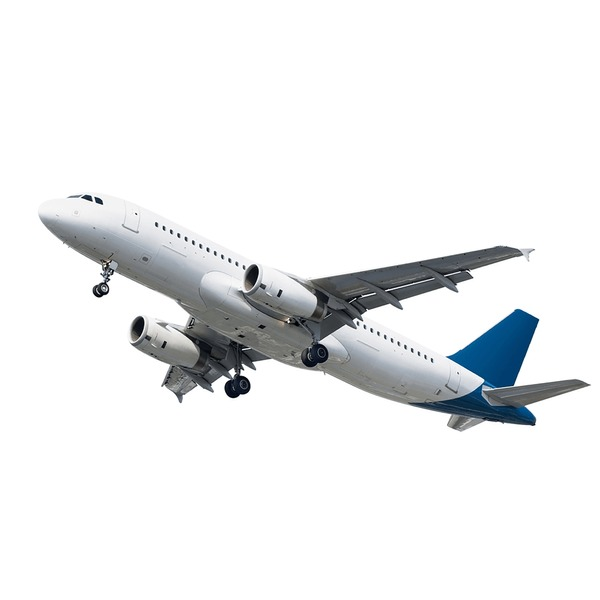

In [36]:
from PIL import Image

img = Image.open(custom_image_paths[0])
img

In [41]:
def test_custom_image(image_path):
  img = Image.open(image_path)
  img = transforms(img)
  img = img.unsqueeze(dim=0)

  with torch.inference_mode():
    output = inception(img.to(device))
    predicted_label = torch.argmax(torch.softmax(output, dim=1), dim=1)
  return predicted_label

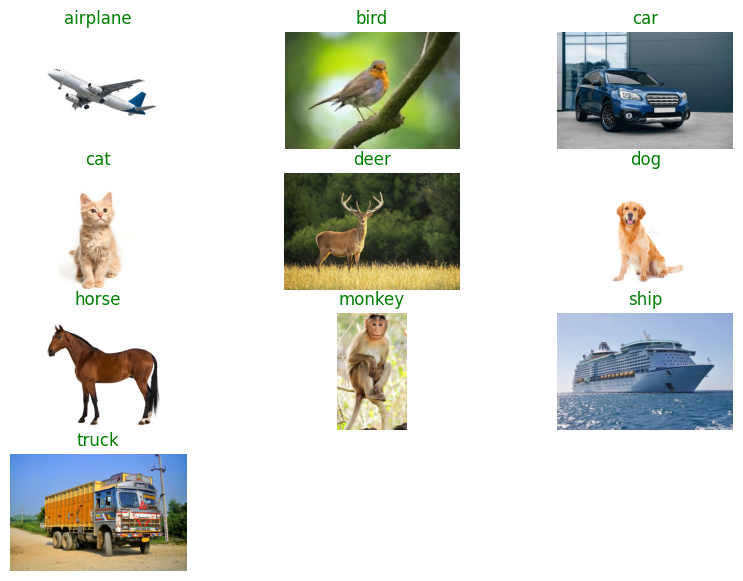

In [46]:
plt.figure(figsize=(10, 7))

for i, image_path in enumerate(custom_image_paths):
  predicted_label = test_custom_image(image_path)
  plt.subplot(4, 3, i+1)
  plt.imshow(Image.open(image_path))
  color = "green" if stl10_classes[predicted_label] == stl10_classes[i] else "red"
  plt.title(stl10_classes[i], color=color)
  plt.axis(False)